# Disc Crop

In [1]:
import numpy as np
import scipy.io as sio
import scipy.misc
from keras.preprocessing import image
from PIL import Image
from skimage.transform import rotate, resize
from skimage.measure import label, regionprops
from time import time
import cv2

from mnet_utils import pro_process, BW_img, disc_crop, mk_dir, return_list
import Model_DiscSeg as DiscModel
import Model_MNet as MNetModel
import matplotlib.pyplot as plt

import sys
import re
import random
import pandas as pd
from glob import glob
from keras.preprocessing.image import ImageDataGenerator

path = '../optic-disc-segment/'
if path not in sys.path:
    sys.path.append(path)
from ipynb.fs.defs.OD_Seg_With_ContourNet import unet_3, read_image_samples, preprocess_MESSIDOR_mask, get_datagen,evaluate_model, \
    find_max_contour, show_data, dice_loss, mean_IOU_gpu, fit_ellipse, mean_IOU

from ipynb.fs.defs.Unet_Train import build_generator, get_dataset_mean_std, read_image_samples,get_norm_image_func, \
    preprocess_mask,get_datagen

Using TensorFlow backend.


In [2]:
def evaluate_model(model, img_gen, mask_gen, channel, ellipse_fitting = False, max_component = False, contour_process=False):
    if type(channel) == int:
        channel = [channel]
    generator = get_datagen(img_gen, mask_gen, shuffle=False, channel=channel)
    
    iou_list = []
    for i in range(len(img_gen)):
        t_image, t_mask = next(generator)
        predicted = model.predict(t_image,verbose=0)

        t_image = t_image[0]
        t_mask = t_mask[0]
        
        iou = []
        for ch in range(len(channel)):
            predicted_mask = BW_img(predicted[0][:,:,ch], 0.5)
            
            if ellipse_fitting:
                max_contour = find_max_contour(predicted_mask)
                ellipse_img, ellipse_params = fit_ellipse(max_contour)
                predicted_mask = np.expand_dims(ellipse_img, axis=-1)

            if max_component:
                max_contour = find_max_contour(predicted_mask)
                predicted_mask = np.expand_dims(find_max_component(max_contour, size=t_image.shape[:2]), axis=-1)

            if contour_process:
                predicted_mask = np.expand_dims(label_values_to_mask(mask_post_process(predicted_mask), IMAGE_SIZE), -1)
            
            iou.append(mean_IOU(t_mask[:,:,ch].squeeze(), predicted_mask.squeeze()))
        iou_list.append(iou)
    iou_list = np.array(iou_list)
    print("The IOU is: %s" % (str(np.mean(iou_list, axis=0))))
    return iou_list

In [3]:
DiscROI_size = 600
DiscSeg_size = 512
CDRSeg_size = 400

DiscSeg_model = unet_3(size_set=(512,512,3))
DiscSeg_model.load_weights('../optic-disc-segment/result/checkpoints/Unet_Disc_MESSIDOR_Best.h5')

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights('./deep_model/MESSIDOR_PT_MNet_best.h5')

In [4]:
'''MESSIDOR'''

IMAGE_SIZE = (512,512)
images_dir = '../../data/fundus-images/MESSIDOR/squared_image/'
masks_dir = '../../data/fundus-images/MESSIDOR/mask/'

image_files = glob(images_dir + "*.png")
masks_files = glob(masks_dir + '*.png')
sort_method = lambda x: int(re.search('[0-9]+', x).group(0))
image_files.sort(key=sort_method)
masks_files.sort(key=sort_method)
images_df = pd.DataFrame(image_files, columns=['filename'])
masks_df = pd.DataFrame(masks_files, columns=['filename'])

train_image_df, vali_image_df, test_image_df = images_df.iloc[:200], images_df.iloc[200:260], images_df.iloc[260:]
train_mask_df, vali_mask_df, test_mask_df = masks_df.iloc[:200], masks_df.iloc[200:260], masks_df.iloc[260:]

In [5]:
channel = [0,1]

image_samples = read_image_samples(train_image_df)
mean,std = get_dataset_mean_std(image_samples)

img_gen_args = dict(featurewise_center=False, featurewise_std_normalization=False, preprocessing_function = get_norm_image_func(mean,std))
mask_gen_args = dict(preprocessing_function = preprocess_mask)

train_image_generator = build_generator(train_image_df, img_gen_args, IMAGE_SIZE, samples=image_samples)
vali_image_generator = build_generator(vali_image_df, img_gen_args, IMAGE_SIZE, samples=image_samples)
test_image_generator = build_generator(test_image_df, img_gen_args, IMAGE_SIZE, samples=image_samples)
train_mask_generator = build_generator(train_mask_df, mask_gen_args, IMAGE_SIZE)
vali_mask_generator = build_generator(vali_mask_df, mask_gen_args, IMAGE_SIZE)
test_mask_generator = build_generator(test_mask_df, mask_gen_args, IMAGE_SIZE)

# del image_samples

# combine generators into one which yields image and masks
train_generator = get_datagen(train_image_generator, train_mask_generator,shuffle=True, channel=channel)
vali_generator = get_datagen(vali_image_generator, vali_mask_generator, shuffle=False, channel=channel)
test_generator = get_datagen(test_image_generator, test_mask_generator, shuffle=False, channel=channel)

[0.42642656 0.21543424 0.08097636]
[0.31391786 0.16513763 0.07199171]
Found 200 images.
Found 60 images.
Found 200 images.
Found 200 images.
Found 60 images.
Found 200 images.


In [6]:
iou_list = evaluate_model(DiscSeg_model,test_image_generator, test_mask_generator, channel=0, ellipse_fitting=True)

The IOU is: [0.9272747]


In [17]:
idx=0
fitting = False
target_size = (2048, 2048)
ious = []
generator = get_datagen(train_image_generator, train_mask_generator, False)

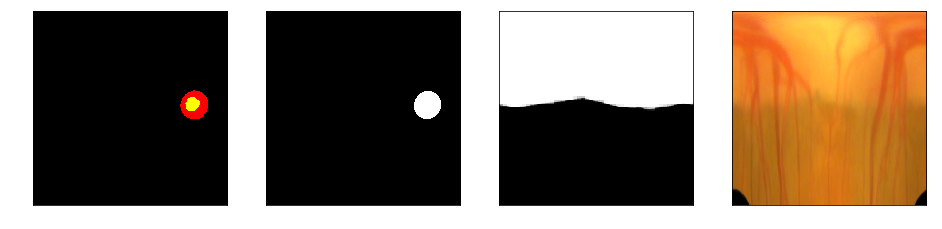

In [39]:
t_image, t_mask2 = next(generator)
img_path = test_image_generator.filenames[idx]
mask_path = test_mask_generator.filenames[idx]
org_img = np.asarray(image.load_img(img_path, target_size=target_size))
t_mask = preprocess_mask(np.asarray(image.load_img(mask_path)))

disc_map = DiscSeg_model.predict(t_image,verbose=0)
disc_map = BW_img(disc_map.squeeze(), 0.5)
disc_map2 = disc_map
regions = regionprops(label(disc_map))
C_x = int(regions[0].centroid[0] * org_img.shape[0] / 512)
C_y = int(regions[0].centroid[1] * org_img.shape[1] / 512)
disc_region, err_xy, crop_xy = disc_crop(org_img, DiscROI_size, C_x, C_y)

# Disc and Cup segmentation by M-Net
Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size/2, DiscROI_size/2),
                                   DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)

temp_img = pro_process(Disc_flat, CDRSeg_size)
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
[_, _, _, _, prob_10] = CDRSeg_model.predict(temp_img)


# Extract mask
prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
# scipy.misc.imresize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
disc_map = np.array(Image.fromarray(prob_map[:, :, 0]).resize((DiscROI_size, DiscROI_size))) 
cup_map = np.array(Image.fromarray(prob_map[:, :, 1]).resize((DiscROI_size, DiscROI_size))) 
disc_map[-round(DiscROI_size / 3):, :] = 0
cup_map[-round(DiscROI_size / 2):, :] = 0
De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                              DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                             DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)

# Save raw mask
ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) + np.array(BW_img(De_cup_map, 0.5), dtype=int)
Img_result = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
Img_result[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ROI_result[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
Img_result = np.array(Image.fromarray(Img_result).resize(t_mask.shape[:-1]))

max_contour = find_max_contour(ROI_result)
ellipse_img, ellipse_params = fit_ellipse(max_contour, size=ROI_result.shape)
fitted_result = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
fitted_result[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ellipse_img[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
fitted_result = np.array(Image.fromarray(fitted_result).resize(t_mask.shape[:-1]))
idx += 1
show_data(t_mask.astype(float), fitted_result, prob_map[:,:,0], temp_img)

In [18]:
# def evaluate(model, image_gen, mask_gen)
for idx in range(len(train_image_generator)):
    t_image, t_mask2 = next(generator)
    img_path = train_image_generator.filenames[idx]
    mask_path = train_mask_generator.filenames[idx]
    org_img = np.asarray(image.load_img(img_path, target_size=target_size))
    t_mask = preprocess_mask(np.asarray(image.load_img(mask_path)))

    disc_map = DiscSeg_model.predict(t_image,verbose=0)
    disc_map = BW_img(disc_map.squeeze(), 0.5)
    disc_map2 = disc_map
    regions = regionprops(label(disc_map))
    C_x = int(regions[0].centroid[0] * org_img.shape[0] / 512)
    C_y = int(regions[0].centroid[1] * org_img.shape[1] / 512)
    disc_region, err_xy, crop_xy = disc_crop(org_img, DiscROI_size, C_x, C_y)

    # Disc and Cup segmentation by M-Net
    Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size/2, DiscROI_size/2),
                                       DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)

    temp_img = pro_process(Disc_flat, CDRSeg_size)
    temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
    [_, _, _, _, prob_10] = CDRSeg_model.predict(temp_img)


    # Extract mask
    prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
    # scipy.misc.imresize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
    disc_map = np.array(Image.fromarray(prob_map[:, :, 0]).resize((DiscROI_size, DiscROI_size))) 
    cup_map = np.array(Image.fromarray(prob_map[:, :, 1]).resize((DiscROI_size, DiscROI_size))) 
    disc_map[-round(DiscROI_size / 3):, :] = 0
    cup_map[-round(DiscROI_size / 2):, :] = 0
    De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                  DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
    De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                 DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

    De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
    De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)

    # Save raw mask
    ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) # + np.array(BW_img(De_cup_map, 0.5), dtype=int)
    
    if fitting:
        max_contour = find_max_contour(ROI_result)   
        ROI_result, ellipse_params = fit_ellipse(max_contour, size=ROI_result.shape)
    
    Img_result = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
    Img_result[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ROI_result[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
    Img_result = np.array(Image.fromarray(Img_result).resize(t_mask.shape[:-1]))
    
    
    ROI_result2 = np.array(BW_img(De_cup_map, 0.5), dtype=int) # + np.array(BW_img(De_cup_map, 0.5), dtype=int)
    
    if fitting:
        max_contour = find_max_contour(ROI_result2)   
        ROI_result2, ellipse_params = fit_ellipse(max_contour, size=ROI_result2.shape)
    
    Img_result2 = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
    Img_result2[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ROI_result2[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
    Img_result2 = np.array(Image.fromarray(Img_result2).resize(t_mask.shape[:-1]))

#     max_contour = find_max_contour(ROI_result)   
#     ellipse_img, ellipse_params = fit_ellipse(max_contour, size=ROI_result.shape)
#     fitted_result = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
#     fitted_result[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ellipse_img[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
#     fitted_result = np.array(Image.fromarray(fitted_result).resize(t_mask.shape[:-1]))

#     show_data(t_mask, Img_result, ROI_result)

    # print(mean_IOU(t_mask2, disc_map2))
    # print(mean_IOU(t_mask, Img_result)) 
    ious.append([mean_IOU(t_mask2, disc_map2), mean_IOU(t_mask[:,:,0], Img_result), mean_IOU(t_mask[:,:,1], Img_result2)])
    print(idx)
# iou_df = pd.DataFrame(ious, columns=['step1', 'step2', 'fitted'])
iou_df = pd.DataFrame(ious, columns=['step1', 'step2_disc', 'step2_cup'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [12]:
# test
iou_df.mean()

step1         0.924833
step2_disc    0.941438
step2_cup     0.829810
dtype: float64

In [9]:
# test fit ellipse
iou_df.mean()

step1         0.924833
step2_disc    0.939599
step2_cup     0.836304
dtype: float64

In [16]:
# vali
iou_df.mean()

step1         0.932107
step2_disc    0.941003
step2_cup     0.839380
dtype: float64

In [19]:
# Train
iou_df.mean()

step1         0.950486
step2_disc    0.956402
step2_cup     0.893199
dtype: float64

In [11]:
iou_df.fitted.mean()

0.9431632340895368

In [58]:
iou_df.step2.mean()

0.94379096113591

In [447]:
iou_df.step2.mean()

0.9483250032964325